<a href="https://colab.research.google.com/github/jrg70/CoAmo2D/blob/main/CoAmo2D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Amorphization prediction by using 2D molecule representations**

In this article, a keras based prediction of amorphization experiments is coded.

Load all necessary packages

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from keras.preprocessing import image
from keras.preprocessing.image import load_img, ImageDataGenerator
import warnings
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
from sklearn.utils import shuffle

Connect to google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Name all experimentally used molecules and upload their 2D picutres (RGB and 500x500) 

In [ ]:
molecules = ['2-Nitrobenzamide.png','2-Nitrobenzoicacid.png',"3,3'-Thiodipropionicacid.png",'3-Fluorobenzamide.png',
             '3-Methoxybenzoicacid.png','4-Aminobenzoicacid.png','4-Hydroxybenzamide.png','4-Methylbenzamide.png','4-Nitrobenzamide.png',
             'Trans-Aconiticacid.png','Anthranilicacid.png','L-Ascorbicacid.png','Acetylsalicylicacid.png','Benzoicacid.png',"4,4'-Bipyridine.png",
             'Caffeine.png','Carbamazepine.png','Citricacid.png','Diclofenac.png','Folicacid.png','L-Glutamicacid.png',
             'Ibuprofene.png','L-Isoleucine.png','Isonicotinamide.png','L-Leucine.png','Mesaconicacid.png',
             'Nicotinamide.png','Phenazine.png','Riboflavine.png','Salicylicacid.png','Theobromine.png','Theophylline.png','3-Methylbenzamide.png']

im = []
for i in molecules:
  dir = ('drive/MyDrive/Colab Notebooks/Molecules/'+ i)
  im1 = load_img(dir)
  im2 = im1.resize((100,100))
  im.append(im2)


Let's look at some images and check if everything is in place. By chaning the IMG_INDEX we can look at the different molecules.

L-Glutamicacid.png


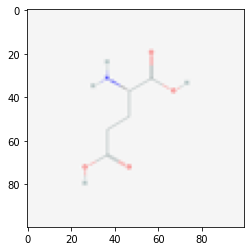

In [ ]:
IMG_INDEX = 20
print(molecules[IMG_INDEX])
plt.imshow(im[IMG_INDEX] ,cmap=plt.cm.binary)
plt.show()

Upload the result matrix

In [ ]:
results = pd.read_csv('drive/MyDrive/Colab Notebooks/Molecules/Results.csv')
print(results)


                   Component1            Component2  Outcome
0    3,3'-Thiodipropionicacid       4,4'-Bipyridine        1
1    3,3'-Thiodipropionicacid   Acetylsalicylicacid        0
2    3,3'-Thiodipropionicacid       Anthranilicacid        0
3    3,3'-Thiodipropionicacid           Benzoicacid        0
4    3,3'-Thiodipropionicacid              Caffeine        0
..                        ...                   ...      ...
433                 Folicacid  3-Methoxybenzoicacid        0
434                 Folicacid      2-Nitrobenzamide        1
435                 Folicacid      4-Nitrobenzamide        1
436                 Folicacid     3-Methylbenzamide        0
437                 Folicacid     4-Methylbenzamide        0

[438 rows x 3 columns]


Define the function that combines both molecules horizontally.

In [ ]:
def get_concat_h(im1, im2):
    dst = Image.new('RGB', (im1.width + im2.width, im1.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (im1.width, 0))
    return dst

Execute the function on the result matrix.

In [ ]:
CC = []
for i in range(len(results)):
  A = im[molecules.index(results.iloc[i][0]+'.png')]
  B = im[molecules.index(results.iloc[i][1]+'.png')]
  C = shuffle([A,B])
  AB = get_concat_h(C[0],C[1])
  pix_arr = np.array(AB) / 255.0
  CC.append(pix_arr)
CC = tf.stack(CC)

Let's look at some images and check if everything is in place. By chaning the IMG_INDEX we can look at the different molecule pairs

3,3'-Thiodipropionicacid and 3-Methoxybenzoicacid


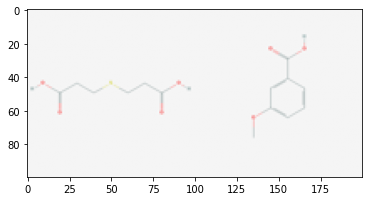

In [ ]:
IMG_INDEX = 20
print(results.iloc[IMG_INDEX][0]+' and '+results.iloc[IMG_INDEX][1])
plt.imshow(CC[IMG_INDEX] ,cmap=plt.cm.binary)
plt.show()

Define classes and the labels of the results

In [ ]:
classes = ['1','0']
CC_labels = results['Outcome']
CC_labels = tf.stack(CC_labels)

Building the **convolutional base**

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(100,200, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

Let's have a look at the model so far


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 198, 32)       896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 99, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 97, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 48, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 46, 64)        36928     
Total params: 56,320
Trainable params: 56,320
Non-trainable params: 0
_________________________________________________________________


Adding **dense layer**

In [ ]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(2))

Training

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(CC, CC_labels, epochs=1)

14/14 [==============================] - 10s 647ms/step - loss: 1.1864 - accuracy: 0.5525


Augmentation

In [ ]:
datagen = ImageDataGenerator(
rotation_range=40,
width_shift_range=0.2,
height_shift_range=0.2,
shear_range=0.2,
zoom_range=0.2,
horizontal_flip=True,
fill_mode='nearest')

CC_Aug = []
CC_Aug_labels = []

for k in range(len(results)):
  test_img = CC[k]
  img = image.img_to_array(test_img)
  img = img.reshape((1,) + img.shape)  
  i = 0
  for batch in datagen.flow(img):
    img = tf.reshape(img,CC[0].shape)
    CC_Aug.append(img)
    CC_Aug_labels.append(CC_labels[k])
    i += 1
    if i > 4:
        break

In [ ]:
CC_new = tf.concat([CC,CC_Aug],0)
CC_labels_new = tf.concat([CC_labels,CC_Aug_labels],-1)

In [ ]:
CC_new = tf.random.shuffle(CC_new,1)
CC_labels_new = tf.random.shuffle(CC_labels_new,1)

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(100,200, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(2))

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(CC_new, CC_labels_new, epochs=5)

Epoch 1/5
83/83 [==============================] - 151s 2s/step - loss: 0.7944 - accuracy: 0.5845
Epoch 2/5
83/83 [==============================] - 150s 2s/step - loss: 0.6754 - accuracy: 0.6027
Epoch 3/5
83/83 [==============================] - 153s 2s/step - loss: 0.6782 - accuracy: 0.5982
Epoch 4/5
83/83 [==============================] - 154s 2s/step - loss: 0.6776 - accuracy: 0.6027
Epoch 5/5
83/83 [==============================] - 154s 2s/step - loss: 0.6748 - accuracy: 0.6012
